## Scenario

Food trucks have been growing since it was known to the public. The main aim of the food truck is to take the food to the customers. The business plan would be successful if the truck was aimed at the right target customers. Unlike traditional restaurant and fast food chains, the food is cooked at that moment and served fresh to the customer. The turnaround time for the customer's orders should be quick to satisfy customers. The following business problem section is based on this scenario.

### 1. Business Problem

A client of mine who is based in Houston, Texas, wants to start a food truck with the concept of selling middle eastern cuisine. It mainly concentrates on foods like shawarma, wraps, salads with hummus etc. These foods are pretty quick to cook and serve to the customers. The main goal of the client is to aim at the customers like students, business employees, constructions sites, public parks, or mostly commonly visited places by the public. The challenge is to find the top three neighborhoods among the most popular neighborhoods in Houston, Texas so that my client can kick-start their business and estimate the turn out profits in the next two to three years by concentrating on the top three neighborhoods.

This business problem mainly concentrates on finding the top three neighborhoods to start the food truck business.

### 2.Data

##### Sources: 

1. List of super neighborhoods in Houston, TX: http://www.city-data.com/nbmaps/neigh-Houston-Texas.html (Link changed due to inaccurate data in wikipedia)
2. FourSquare data to find the popular venues

##### How will the data be used to answer the business needs?
The data mentioned above will be used to explore and target locations across different venues present in the neighborhoods. 

1. Use Foursquare and geopy data to map top venues for the super neighborhoods of Houston and cluster them in groups
2. City-Data to get the neighborhoods information
3. Additional data will be added from open data sources if available in the future if the data is insufficient

By extracting the venues of the neighborhoods we can determine the most visited venues which would determine that the customer count is high in that area. By using Foursquare data and the Houston's neighborhood data, we can recommend the top three neighborhoods by performing machine learning techniques and can visualize them through a graph or a map. 

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # 
!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

#Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # 
!pip install  folium 
import folium # map rendering library

#!conda install -c conda-forge lxml --yes
!pip install lxml
#Lib for html handling
from lxml import html

#Beautiful soup to extract the neighborhoods names
!pip install beautifulsoup4
from bs4 import BeautifulSoup

print('Libraries imported.')

     |████████████████████████████████| 102kB 18.5MB/s ta 0:00:01
     |████████████████████████████████| 5.8MB 4.0MB/s eta 0:00:01
     |████████████████████████████████| 112kB 7.4MB/s eta 0:00:01
Libraries imported.


##### Storing the neighborhoods data into the dataframe

In [2]:
#Extracting the xml using beautiful soup
url = requests.get('http://www.city-data.com/nbmaps/neigh-Houston-Texas.html').text
soup = BeautifulSoup(url,'lxml')

In [3]:
#Finding neighborhoods and converting them to lists
mydivs = soup.findAll("span", {"class": "street-name"})
data =[]
for i in mydivs:
    data.append(i.text)

In [4]:
#Converting the neighborhoods list to dataframe
df_Houston = pd.DataFrame(data)
df_Houston = df_Houston.rename(columns={df_Houston.columns[0]: 'Neighborhood'})
df_Houston.head()

,Neighborhood
0,Acres Homes
1,Alden Bridge
2,Alief
3,Allendale
4,Astrodome


##### Using Geo Py to retrieve the longitude and latitude of Houston

In [5]:
address = 'Houston, TX'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print("Geographical co-ordinates of Houston, TX are (lat):{} and (long): {}".format(latitude, longitude))

Geographical co-ordinates of Houston, TX are (lat):29.7589382 and (long): -95.3676974


Script to extract the latitude and longitudes of the neighborhood using geo locator 

In [6]:
#Create lists for lat and long
lat = []
lng = []

#Loop through all neigborhoods in Helsinki
for adr in df_Houston['Neighborhood']:
    #Use geolocator to get coordinates of neigborhoods within Houston
    loc = geolocator.geocode(adr+','+ 'Houston'+','+'TX')
    if loc == None:
        lat.append('NAN')
        lng.append('NAN')
    #Append coordinates to lists
    else:
        lat.append(loc.latitude)
        lng.append(loc.longitude)

#Map coordinate lists to data frame 

df_Houston['lat'] = lat
df_Houston['lng'] = lng

##### Following dataframe consists of neighborhoods and their latitudes and longitudes that can be used for clustering the venues according the neighborhoods

In [7]:
df_Houston.head()

,Neighborhood,lat,lng
0,Acres Homes,29.8647,-95.4309
1,Alden Bridge,NAN,NAN
2,Alief,29.7111,-95.5963
3,Allendale,29.6941,-95.2463
4,Astrodome,29.6849,-95.4077


### 3. Methodology

Methodology section which represents the main component of the report where you discuss and describe any exploratory data analysis that you did, any inferential statistical testing that you performed, and what machine learnings were used and why.

With above data, I can use the concept of manually assigning weights to calculate a score and predict the most popular neighborhood to resolve the problem.

Combine with FourSquare API which provides how many venues in different category of Schools, Universities and Offices, a matrix which captured characteristic of venues are built. Client's list is the profile to combine with the matrix to become a weighted matrix of most favorable spot.

The weighted matrix can be applied on several target locations with venues information to generate a ranking result by using indexes. The the top three on the ranking list can be recommended to the client.

Before building the matrix, I have to prepare the required data and apply some data analysis.

In [8]:
df_Houston.head()

,Neighborhood,lat,lng
0,Acres Homes,29.8647,-95.4309
1,Alden Bridge,NAN,NAN
2,Alief,29.7111,-95.5963
3,Allendale,29.6941,-95.2463
4,Astrodome,29.6849,-95.4077


Data was pre-processed in the Data section. Here we will refine the data according to our requirements and drop rows which we do not need.

Since geopy was not able to find the co-ordinates of few Neighborhoods due to data not being accurate or could be any other reason, we drop those rows.

In [9]:
df_Houston = df_Houston[df_Houston['lat'] != 'NAN']
df_Houston = df_Houston.rename(columns = {"lat": "Latitude", "lng": "Longitude"})
print(df_Houston.shape)
df_Houston.head()

(85, 3)


,Neighborhood,Latitude,Longitude
0,Acres Homes,29.8647,-95.4309
2,Alief,29.7111,-95.5963
3,Allendale,29.6941,-95.2463
4,Astrodome,29.6849,-95.4077
6,Binz,29.7249,-95.3881


Now we map the houston neighborhoods using folium

In [10]:
# create map of Houston using latitude and longitude values of the super neighborhoods
Houston_map = folium.Map(location=[latitude, longitude], zoom_start=11)

for index, row in df_Houston.iterrows():

    adr = row['Neighborhood']
    lat = row['Latitude']
    lng = row['Longitude']

    label = '{}'.format(adr)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Houston_map)  

Houston_map.save('HoustonMap_SuperNeighborhoods.html')

From the map I can observe that the super neighborhoods are spread across the map. My next step is to use foursquare API and get the venues of those neighborhoods.

In [11]:
#Defining foursquare API credentials and limit of the venues of each neighborhood

CLIENT_ID = 'ZG4PTBXMTKNZQWSFJBDJYS0ZHOLDR5BRFTJZCYL2Y3FAXMR0' # your Foursquare ID
CLIENT_SECRET = 'BQPQT4PJPQYZVNDRCEXKLB2UI4KK1B21AFBLEP2OBOSH1IKA' # your Foursquare Secret
VERSION = '201901201' # Foursquare API version

Limit = 300 # limit of number of venues returned by Foursquare API
radius = 750 # define radius

##### Defining a function to get the nearby venues of each neighbourhood using foursquare API

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=750, categoryIds=''):
    
    venues_list=[]
    print('Venues for the Houston Neighborhoods are being retrieved:')
    for name, lat, lng in zip(names, latitudes, longitudes):

            
        # creating an API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            Limit)
        
        if(categoryIds!=''):
            url = url+'&categoryId={}'
            url = url.format(categoryIds)
        
        #Get Request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        venues_list.append([(
                   name, 
                   lat, 
                   lng, 
                   v['venue']['name'], 
                   v['venue']['location']['lat'], 
                   v['venue']['location']['lng'],
                   v['venue']['categories'][0]['id'],
                   v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue ID',
                  'Venue Category']
    print('Data Retrieved')    
    return(nearby_venues)



##### Defining a function to add markers for given venues to map

In [13]:

def addToMap(df, color, existingMap):
    for lat, lng, local, venue, venueCat in zip(df['Venue Latitude'], df['Venue Longitude'], df['Neighborhood'], df['Venue'], df['Venue Category']):
        label = '{} ({}) - {}'.format(venue, venueCat, local)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7).add_to(existingMap)

##### Now we retrieve specific venues by passing the category IDs. Category IDs are listed in the following Foursquare API documentation.

https://developer.foursquare.com/docs/resources/categories

In [14]:
#Retrieving the data for the neighbourhoods to get only food trucks 

houston_Venues_FoodTruck = getNearbyVenues(names=df_Houston['Neighborhood'],
                                        latitudes=df_Houston['Latitude'],
                                        longitudes=df_Houston['Longitude'],
                                         radius=750,
                                         categoryIds='4bf58dd8d48988d1cb941735'
                                )

Venues for the Houston Neighborhoods are being retrieved:
Data Retrieved


In [15]:
print(houston_Venues_FoodTruck.shape)
houston_Venues_FoodTruck_grouped = houston_Venues_FoodTruck.groupby('Neighborhood').count().sort_values(by=['Venue']).reset_index()
houston_Venues_FoodTruck_grouped.head()

(172, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue ID,Venue Category
0,Allendale,1,1,1,1,1,1,1
1,Third Ward,1,1,1,1,1,1,1
2,Spring,1,1,1,1,1,1,1
3,South Acres,1,1,1,1,1,1,1
4,Park Place,1,1,1,1,1,1,1


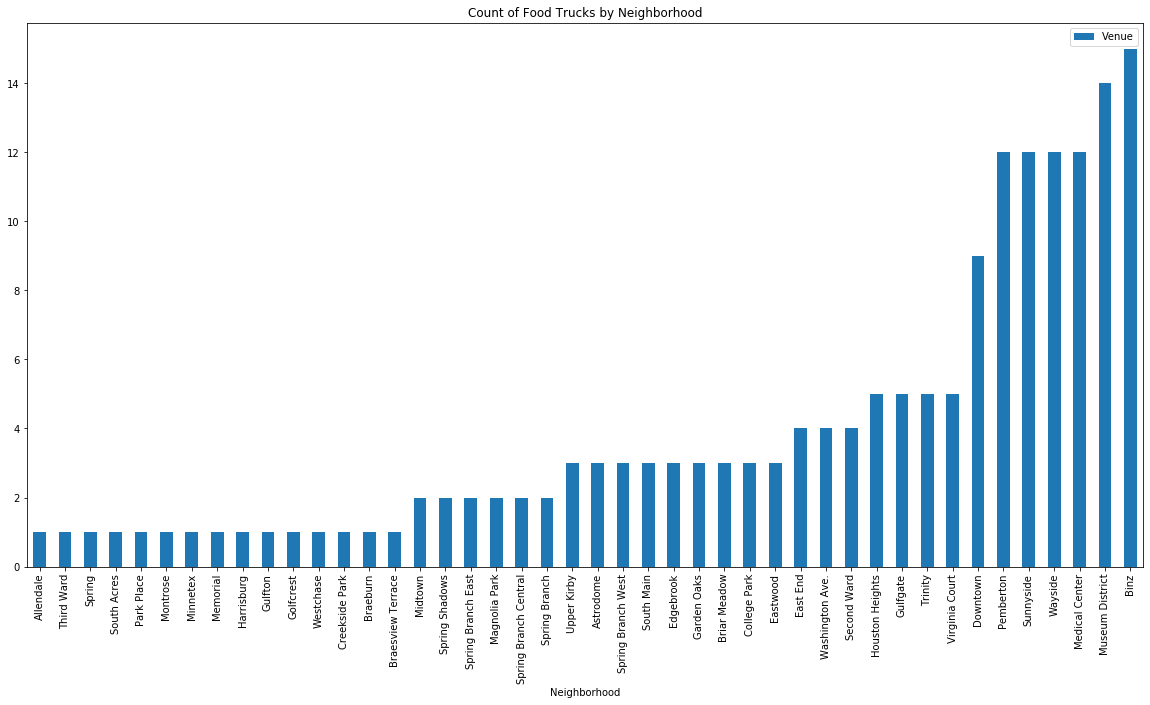

In [39]:
houston_Venues_FoodTruck_grouped.plot.bar(x='Neighborhood'
                                          , y = 'Venue'
                                          , rot =90
                                          , figsize=(20, 10)
                                          , title='Count of Food Trucks by Neighborhood'
                                         )


From the bar graph above we can observe that the count of food trucks is high in the following Neighborhoods,
1. Binz
2. Museum District 
3. Medical center

But this information is not sufficient. We will be retrieving the data for the following venues with schools, universities, offices, public parks and additional information if required.

In [17]:
#Retrieving the data for the neighbourhoods to get only Schools

houston_Venues_Schools = getNearbyVenues(names=df_Houston['Neighborhood'],
                                        latitudes=df_Houston['Latitude'],
                                        longitudes=df_Houston['Longitude'],
                                         radius=1500,
                                         categoryIds='4bf58dd8d48988d13d941735'
                                )

Venues for the Houston Neighborhoods are being retrieved:
Data Retrieved


In [18]:
print(houston_Venues_Schools.shape)
houston_Venues_Schools.head()

(255, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue ID,Venue Category
0,Acres Homes,29.864718,-95.430858,Williams High School,29.853281,-95.423828,4bf58dd8d48988d13d941735,High School
1,Alief,29.711064,-95.596334,Hastings High School - Alief ISD,29.709626,-95.597551,4bf58dd8d48988d13d941735,High School
2,Alief,29.711064,-95.596334,Hastings Ninth Grade center,29.706338,-95.598372,4bf58dd8d48988d13d941735,High School
3,Alief,29.711064,-95.596334,Elsik High School,29.709747,-95.603051,4bf58dd8d48988d13d941735,High School
4,Alief,29.711064,-95.596334,Hastings Ninth Grade Center - Alief ISD,29.706800,-95.603472,4bf58dd8d48988d13d941735,High School


In [19]:
map_houston_schools = folium.Map(location=[latitude, longitude], zoom_start=12)
addToMap(houston_Venues_Schools, 'green', map_houston_schools)
map_houston_schools.save('map_houston_schools.html')

In [20]:
#Retrieving the data for the neighbourhoods to get only Universities

houston_Venues_University = getNearbyVenues(names=df_Houston['Neighborhood'],
                                        latitudes=df_Houston['Latitude'],
                                        longitudes=df_Houston['Longitude'],
                                         radius=1500,
                                         categoryIds='4bf58dd8d48988d1ae941735'
                                )

Venues for the Houston Neighborhoods are being retrieved:
Data Retrieved


In [21]:
print(houston_Venues_University.shape)
houston_Venues_University.head()

(130, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue ID,Venue Category
0,Astrodome,29.684870,-95.407743,SHSU Agriculture Alumni Booth HLSR,29.686533,-95.405697,4bf58dd8d48988d1ae941735,University
1,Binz,29.724918,-95.388131,RICE george R brown school of engineering,29.721471,-95.393322,4bf58dd8d48988d1ae941735,University
2,Binz,29.724918,-95.388131,Community Cinema @ Rice Cinema,29.720576,-95.393665,4bf58dd8d48988d1ae941735,University
3,Binz,29.724918,-95.388131,President's House (Rice University),29.721176,-95.394520,4bf58dd8d48988d1ae941735,University
4,Binz,29.724918,-95.388131,Entrance 1 Drive,29.720385,-95.393939,4bf58dd8d48988d1ae941735,University


In [22]:
map_houston_university = folium.Map(location=[latitude, longitude], zoom_start=12)
addToMap(houston_Venues_University, 'red', map_houston_university )
map_houston_university.save('map_houston_university.html')

In [24]:
#Retrieving the data for the neighbourhoods to get only Offices

houston_Venues_Offices = getNearbyVenues(names=df_Houston['Neighborhood'],
                                        latitudes=df_Houston['Latitude'],
                                        longitudes=df_Houston['Longitude'],
                                         radius=2000,
                                         categoryIds='4d4b7105d754a06375d81259'
                                )

Venues for the Houston Neighborhoods are being retrieved:
Data Retrieved


In [25]:
print(houston_Venues_Offices.shape)
houston_Venues_Offices.head()

(5583, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue ID,Venue Category
0,Acres Homes,29.864718,-95.430858,In Da Hood,29.871020,-95.426033,4d4b7105d754a06375d81259,Professional & Other Places
1,Acres Homes,29.864718,-95.430858,Mobile 4G Wireless Internet Access from CLEAR,29.863088,-95.425444,4bf58dd8d48988d124941735,Office
2,Acres Homes,29.864718,-95.430858,Champion Rentals Inc,29.862319,-95.413011,4bf58dd8d48988d124941735,Office
3,Acres Homes,29.864718,-95.430858,Archie B. Anderson Academy,29.867489,-95.430381,4bf58dd8d48988d13b941735,School
4,Acres Homes,29.864718,-95.430858,US Post Office,29.869515,-95.413999,4bf58dd8d48988d172941735,Post Office


In [26]:
map_houston_office = folium.Map(location=[latitude, longitude], zoom_start=12)
addToMap(houston_Venues_Offices, 'blue', map_houston_office )
map_houston_office.save('map_houston_office.html')

In [27]:
#Retrieving the data for the neighbourhoods to get only Shopping Mall

houston_Venues_ShoppingMall = getNearbyVenues(names=df_Houston['Neighborhood'],
                                        latitudes=df_Houston['Latitude'],
                                        longitudes=df_Houston['Longitude'],
                                         radius=500,
                                         categoryIds='4bf58dd8d48988d1fd941735'
                                )


Venues for the Houston Neighborhoods are being retrieved:
Data Retrieved


In [28]:
print(houston_Venues_ShoppingMall.shape)
houston_Venues_ShoppingMall.head()

(10, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue ID,Venue Category
0,Creekside Park,32.804376,-79.891047,Village Pointe Shopping Center,32.802445,-79.891244,4bf58dd8d48988d1fd941735,Shopping Mall
1,Medical Center,29.758938,-95.367697,Houston Tunnels,29.758460,-95.365293,4bf58dd8d48988d1fd941735,Shopping Mall
2,Medical Center,29.758938,-95.367697,Wedge International Tower,29.754994,-95.369960,4bf58dd8d48988d130941735,Building
3,Pemberton,29.758938,-95.367697,Houston Tunnels,29.758460,-95.365293,4bf58dd8d48988d1fd941735,Shopping Mall
4,Pemberton,29.758938,-95.367697,Wedge International Tower,29.754994,-95.369960,4bf58dd8d48988d130941735,Building


In [40]:
map_houston_mall = folium.Map(location=[latitude, longitude], zoom_start=12)
addToMap(houston_Venues_ShoppingMall, 'yellow', map_houston_mall )
map_houston_mall.save('map_houston_mall.html')

Now we have the most visited or busiest places among the neighborhoods. Next step is to merge the columns.

In [30]:
def addColumn(startDf, columnTitle, dataDf):
    grouped = dataDf.groupby('Neighborhood').count()
    
    for n in startDf['Neighborhood']:
        try:
            startDf.loc[startDf['Neighborhood'] == n,columnTitle] = grouped.loc[n, 'Venue']
        except:
            startDf.loc[startDf['Neighborhood'] == n,columnTitle] = 0

In [31]:
df_houston_merged = df_Houston

#adding count columns for schools to the pre processed houston data
addColumn(df_houston_merged, 'Schools', houston_Venues_Schools)

#adding count columns for university to the pre processed houston data
addColumn(df_houston_merged, 'University', houston_Venues_University)

#adding count columns for offices to the pre processed houston data
addColumn(df_houston_merged, 'Offices', houston_Venues_Offices)

#adding count columns for shopping malls to the pre processed houston data
addColumn(df_houston_merged, 'Shopping Mall', houston_Venues_ShoppingMall)

#adding count columns for shopping malls to the pre processed houston data
addColumn(df_houston_merged, 'Food Truck', houston_Venues_FoodTruck)

df_houston_merged.head()

,Neighborhood,Latitude,Longitude,Schools,University,Offices,Shopping Mall,Food Truck
0,Acres Homes,29.8647,-95.4309,1.0,0.0,33.0,0.0,0.0
2,Alief,29.7111,-95.5963,4.0,0.0,79.0,0.0,0.0
3,Allendale,29.6941,-95.2463,3.0,0.0,21.0,0.0,1.0
4,Astrodome,29.6849,-95.4077,1.0,1.0,100.0,0.0,3.0
6,Binz,29.7249,-95.3881,4.0,12.0,100.0,0.0,15.0


Now Assigning weights. Since we do not want to concur with other food trucks, we assign 
1. Negative weight, because client wants to run the truck where the competition is less
2. Positive weight, because the traffic would be high in the mall area during workdays and weekends
3. Positive weight, because traffic during before and after school hours would be high during workdays
4. Positive weight, because university students would be frequent customers
5. Positive weight, because employees would like to have a quick lunch and get back to work and the traffic will be more compared to others

In [32]:
#Assigning weights
weight_Truck = -1
weight_mall = 1.5
weight_schools = 1
weight_uni = 1.5
weight_offices = 2

Now we create a matrix with the weights assigned and calculate the score. Then we sort it by descending order. 

x = (y * i) + (y1 * i1)+...........+(n * m)

Formula In-efficient for large dataset

In [33]:
df_houston_weighted = df_houston_merged

df_houston_weighted['Weighted Score'] = df_houston_merged['Food Truck'] * weight_Truck + df_houston_merged['Schools'] * weight_schools + df_houston_merged['University'] * weight_uni + df_houston_merged['Offices'] * weight_offices + df_houston_merged['Shopping Mall'] * weight_mall

df_houston_weighted = df_houston_weighted.sort_values(by=['Weighted Score'], ascending = False).reset_index(drop = True)
df_houston_weighted.head(10)

,Neighborhood,Latitude,Longitude,Schools,University,Offices,Shopping Mall,Food Truck,Weighted Score
0,Memorial,29.7186,-95.3909,1.0,15.0,100.0,0.0,1.0,222.5
1,Third Ward,29.7284,-95.3499,3.0,15.0,96.0,0.0,1.0,216.5
2,Medical Center,29.7589,-95.3677,8.0,7.0,100.0,2.0,12.0,209.5
3,Wayside,29.7589,-95.3677,8.0,7.0,100.0,2.0,12.0,209.5
4,Museum District,29.7247,-95.3891,4.0,13.0,100.0,0.0,14.0,209.5
5,Pemberton,29.7589,-95.3677,8.0,7.0,100.0,2.0,12.0,209.5
6,Sunnyside,29.7589,-95.3677,8.0,7.0,100.0,2.0,12.0,209.5
7,Sharpstown,29.6849,-95.5156,2.0,4.0,100.0,0.0,0.0,208.0
8,Binz,29.7249,-95.3881,4.0,12.0,100.0,0.0,15.0,207.0
9,Spring Shadows,29.8185,-95.539,59.0,1.0,74.0,0.0,2.0,206.5


### 4. Results

The indexes are the ranks of the neighborhoods

In [34]:
df_foodTruck_topLocations = df_houston_weighted.iloc[:3]

df_foodTruck_topLocations

,Neighborhood,Latitude,Longitude,Schools,University,Offices,Shopping Mall,Food Truck,Weighted Score
0,Memorial,29.7186,-95.3909,1.0,15.0,100.0,0.0,1.0,222.5
1,Third Ward,29.7284,-95.3499,3.0,15.0,96.0,0.0,1.0,216.5
2,Medical Center,29.7589,-95.3677,8.0,7.0,100.0,2.0,12.0,209.5


After the analysis and calculations we can observe the top three neighborhoods in Houston to start are food truck are,

1. Memorial
2. Third Ward
3. Medical Center

Mapping the top three neighborhoods that are predicted during our analysis

In [37]:
map_foodTruck_result = folium.Map(location=[latitude, longitude], zoom_start=11.5)

for lat, lng, neigh in zip(df_foodTruck_topLocations['Latitude'], df_foodTruck_topLocations ['Longitude'], df_foodTruck_topLocations['Neighborhood']):
    label = '{}'.format(neigh)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
    [lat,lng],
    radius=50,
    popup=label,
    color='darkgreen',
    fill_opacity=1.0).add_to(map_foodTruck_result)

for ix in df_foodTruck_topLocations.index[:3]:
    addToMap(houston_Venues_Schools[houston_Venues_Schools['Neighborhood'] == df_foodTruck_topLocations['Neighborhood'][ix]], 'green', map_foodTruck_result)
    addToMap(houston_Venues_University[houston_Venues_University['Neighborhood'] == df_foodTruck_topLocations['Neighborhood'][ix]], 'red', map_foodTruck_result)
    addToMap(houston_Venues_Offices[houston_Venues_Offices['Neighborhood'] == df_foodTruck_topLocations['Neighborhood'][ix]], 'blue', map_foodTruck_result)
    addToMap(houston_Venues_ShoppingMall[houston_Venues_ShoppingMall['Neighborhood'] == df_foodTruck_topLocations['Neighborhood'][ix]], 'yellow', map_foodTruck_result)

map_foodTruck_result.save('FoodTruck_Result.html')

### 5. Discussion

- From our initial analysis we could observe that the top 3 neighborhoods based on the count of food truck per neighborhood were Binz, Museum District and Medical Center

- Client was worried about their competition and wanted me find the least concurrent places where the client can avoid other competitors

- For further analysis we downloaded school, office and university data since they would be great target audience and assigned them weights according to their traffic, and also assigned weight to the trucks data too to avoid concurrence with the other competitors

- Weighted scores are calculated and the result is sorted according to their weighted score which yielded us the top 3 neighborhoods

- We can also suggest the next 3 neighborhoods for the clients according to our analysis which would be 
    - Wayside
    - Museum District
    - Pembertown
    
    
- Limitations
    - Geo py could not yield the results for all the super neighborhoods in houston which were excluded from the data 
    - Accuracy of venues purely depends on Foursquare

### 6. Conclusion

Based on our analysis the client should start their food truck business in the following three neighborhoods,
- Memorial
- Third Ward
- Medical Center

Upon further analysis, the client can also do business in the next three neighborhoods,
- Wayside
- Museum District
- Pembertown